In [320]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
import cv2

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
PRETRAINED = True
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 0


2023-06-28 18:07:40.382531: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-28 18:07:40.382569: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: cmsgpu01.hep.wisc.edu
2023-06-28 18:07:40.382579: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: cmsgpu01.hep.wisc.edu
2023-06-28 18:07:40.382668: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.30.2
2023-06-28 18:07:40.382714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-06-28 18:07:40.382723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 530.30.2


In [145]:
data = np.load("/nfs_scratch/hsharma/MachineLearning/ClusterFinder/data/EMData-validation.npy")
data = np.pad(data, ((0,0), (0,0), (3, 4), (1, 1)), 'constant')

### Cluster Energy Repr Test

In [268]:
data.shape

(11592, 2, 32, 32)

In [290]:
sample = data[10025]

In [294]:
np.unique(sample[1][sample[1]!=0.0])

array([ 1.625, 13.125])

In [319]:
sample[0][sample[1]!=0.0]

array([1.25, 0.  ])

In [296]:
# test where energy exists in cluster algo and not in energy map
filtered_set = set()

for i in range(len(data)):
    test_point = data[i]
    energies_at_clusters = test_point[0][test_point[1]!=0]
    if 0 in energies_at_clusters:
        filtered_set.add(i)

In [298]:
print(len(filtered_set))
filtered_set

198


{61,
 133,
 193,
 385,
 445,
 461,
 463,
 474,
 511,
 664,
 703,
 988,
 1018,
 1072,
 1152,
 1159,
 1337,
 1357,
 1456,
 1501,
 1583,
 1615,
 1650,
 1669,
 1696,
 1810,
 1854,
 1872,
 1926,
 1960,
 2046,
 2243,
 2296,
 2416,
 2441,
 2527,
 2544,
 2599,
 2664,
 2728,
 2782,
 2854,
 2880,
 3094,
 3202,
 3220,
 3221,
 3277,
 3310,
 3349,
 3353,
 3403,
 3406,
 3408,
 3466,
 3575,
 3592,
 3664,
 3708,
 3742,
 3760,
 3796,
 3829,
 3868,
 3904,
 3982,
 4074,
 4117,
 4297,
 4309,
 4339,
 4540,
 4588,
 4600,
 4609,
 4636,
 4686,
 4948,
 4978,
 5062,
 5122,
 5266,
 5272,
 5345,
 5351,
 5407,
 5449,
 5555,
 5574,
 5659,
 5694,
 5740,
 5747,
 5956,
 5987,
 5992,
 6238,
 6286,
 6401,
 6427,
 6574,
 6739,
 6817,
 6835,
 6845,
 6931,
 6973,
 7000,
 7007,
 7030,
 7063,
 7114,
 7189,
 7192,
 7288,
 7325,
 7348,
 7366,
 7396,
 7440,
 7507,
 7571,
 7594,
 7608,
 7693,
 7702,
 7747,
 7765,
 7825,
 7906,
 8086,
 8219,
 8224,
 8233,
 8248,
 8279,
 8344,
 8419,
 8479,
 8573,
 8623,
 8653,
 8707,
 9025,
 9040

### Test Data Prediction

In [6]:
def rd_to_img(i, data):
    # generate mask and images for testing model directly from np
    img_data, mask_data = data[i][0], data[i][1]
    img_data = img_data/np.max(img_data)
    img_data = np.pad(img_data, ((3, 4), (1, 1)), 'constant')
    img_data = 1 - img_data
    img_data = np.array(img_data * 255, dtype = np.uint8)
    img_data = img_data/255.0
    
    mask_data = np.pad(mask_data, ((3, 4), (1, 1)), 'constant')
    mask_data = 1 - mask_data
    
    return img_data, mask_data

In [247]:
BASE_PATH = "/nfs_scratch/hsharma/MachineLearning/ClusterFinder/data/RealDataVImages/"
IMG_PATH = 'input/'
ANNOTATION_PATH = 'annotations/'
num = 10000

input_img_paths = sorted(
    [
        os.path.join(BASE_PATH, IMG_PATH, fname)
        for fname in os.listdir(BASE_PATH+IMG_PATH)
        if fname.endswith(".png") and "(" not in fname
    ]
)[:num]


annotation_img_paths = []

for fname in tqdm(input_img_paths[:num]):
    annp = os.path.join(BASE_PATH, ANNOTATION_PATH, fname.split("/")[-1].replace("img", "annm"))
    if os.path.isfile(annp):
        annotation_img_paths.append(annp)
        input_img_paths.append(fname)
    else:
        pass

input_img_paths = input_img_paths[num:]
len(input_img_paths), len(annotation_img_paths)

100%|██████████| 10000/10000 [00:01<00:00, 5454.54it/s]


(10000, 10000)

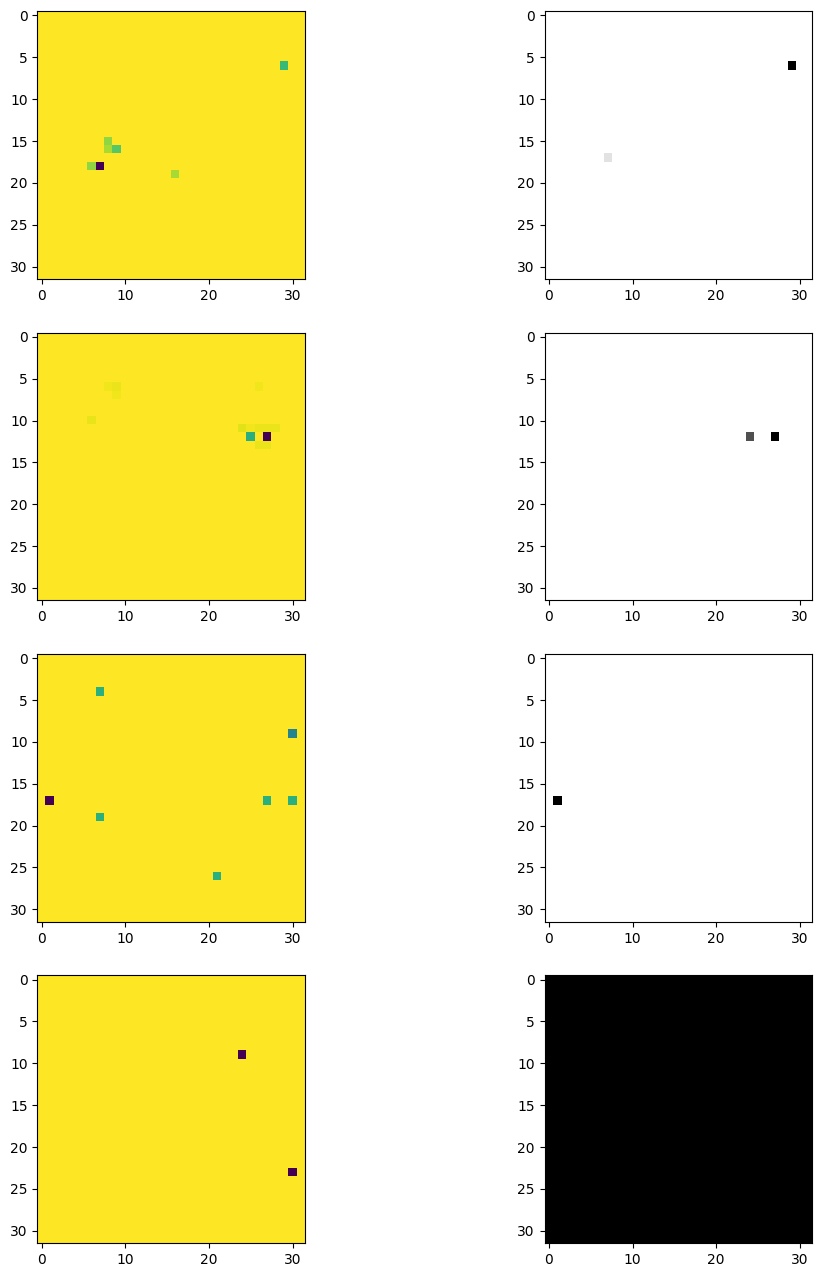

In [248]:
num_example_to_display = 4

sample_idxs = np.random.randint(0, len(data)-1, size=(num_example_to_display,))
sample_idxs = [32, 79, 1, 2]

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=2, figsize=(12,4*num_example_to_display))

for i, sample_idx in enumerate(sample_idxs):
    img = Image.open(input_img_paths[sample_idx]) 
    mask = Image.open(annotation_img_paths[sample_idx])
    mask = np.array(mask)
    mask = mask/np.max(mask) if np.max(mask)>0 else mask
    mask= 1-mask
    axs[i][0].imshow(img)
    axs[i][1].imshow(mask, cmap='gray')

In [249]:
IMG_SHAPE = 32

def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    return image, mask

def load_and_preprocess(img_filepath, mask_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SHAPE, IMG_SHAPE])

    mask = tf.io.read_file(mask_filepath)
    mask = tf.io.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_SHAPE, IMG_SHAPE])

    img, mask = normalize(img, mask)

    return img, mask

In [250]:
from keras.models import load_model

Model_logs = {"ENET": ["run-20230226_175518-8y9uyk1u"], 
             "UNETv2LITE": ["run-20230227_185529-sjhgebn1"],
              "UNETv3LITE": ["run-20230303_140554-80pvvkn4"], # model1
              "UNETv4LITE": ["run-20230308_112406-8zhdka9h"], # model2
             "HEPAENET":["run-20230227_181304-zog286i7"],
             "HEPCONVNET": ["run-20230227_184034-2315xvt8"]}

run_path = "run-20230520_154645-1mdtw3qy"

if PRETRAINED == True:
    MODEL_PATH = "/nfs_scratch/hsharma/MachineLearning/ClusterFinder/notebooks/wandb/"+run_path+"/files/student-model-best.h5"
    model = load_model(MODEL_PATH)

In [251]:
sample_img1, sample_mask1 = rd_to_img(idx, data)
sample_img1 = np.expand_dims(sample_img1, axis=0)

In [373]:
val_imgs, pred_masks, val_masks = [], [], []
for img_path, mask_path in zip(input_img_paths, annotation_img_paths):
    val_img, val_mask = load_and_preprocess(img_path, mask_path)
    data_idx = int(img_path.split(".")[0].split("_")[-1])
    
    val_imgs.append(data[data_idx][0])
    val_masks.append(data[data_idx][1])
    
    val_img = np.expand_dims(val_img, axis=0)
    pred_mask_i = model.predict(val_img)
    pred_mask_i = np.argmax(pred_mask_i, axis=-1)
    pred_mask_i = np.expand_dims(pred_mask_i, axis=-1)
    
    #switch to load, pred and display strategy for scale later
    pred_masks.extend(pred_mask_i)

1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


In [374]:
val_imgs = np.array(val_imgs)
pred_masks = np.array(pred_masks)
val_masks = np.array(val_masks)

In [375]:
pred_masks[np.where(pred_masks == 2)] = 1

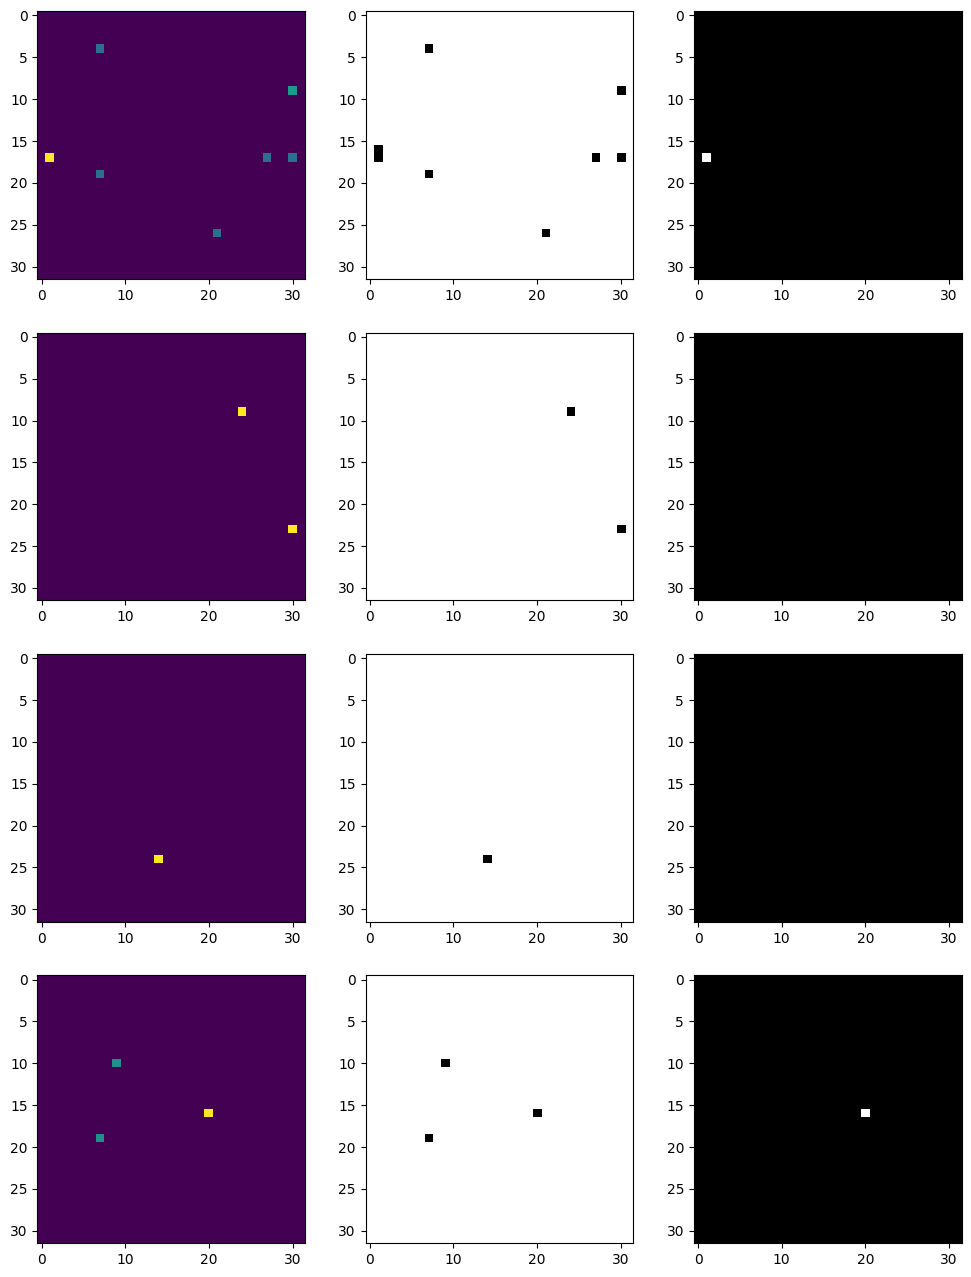

In [376]:
# Prediction Visuals
num_example_to_display = 4
sample_idxs = np.random.randint(0, 10, size=(num_example_to_display,))
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))
sample_idxs = [1,2,3,4]

for i, si in enumerate(sample_idxs):
    axs[i][0].imshow(val_imgs[si])
    axs[i][1].imshow(np.squeeze(pred_masks[si],-1), cmap='gray')
    axs[i][2].imshow(val_masks[si], cmap='gray')

In [377]:
def ccl_generator(pred):
    test_image = np.squeeze(pred).astype("uint8")
    thresh = cv2.threshold(test_image, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    output_pred = cv2.connectedComponentsWithStats(
        thresh, 4, cv2.CV_32S)
    (numLabels_pred, labels_pred, stats_pred, centroids) = output_pred

    return labels_pred

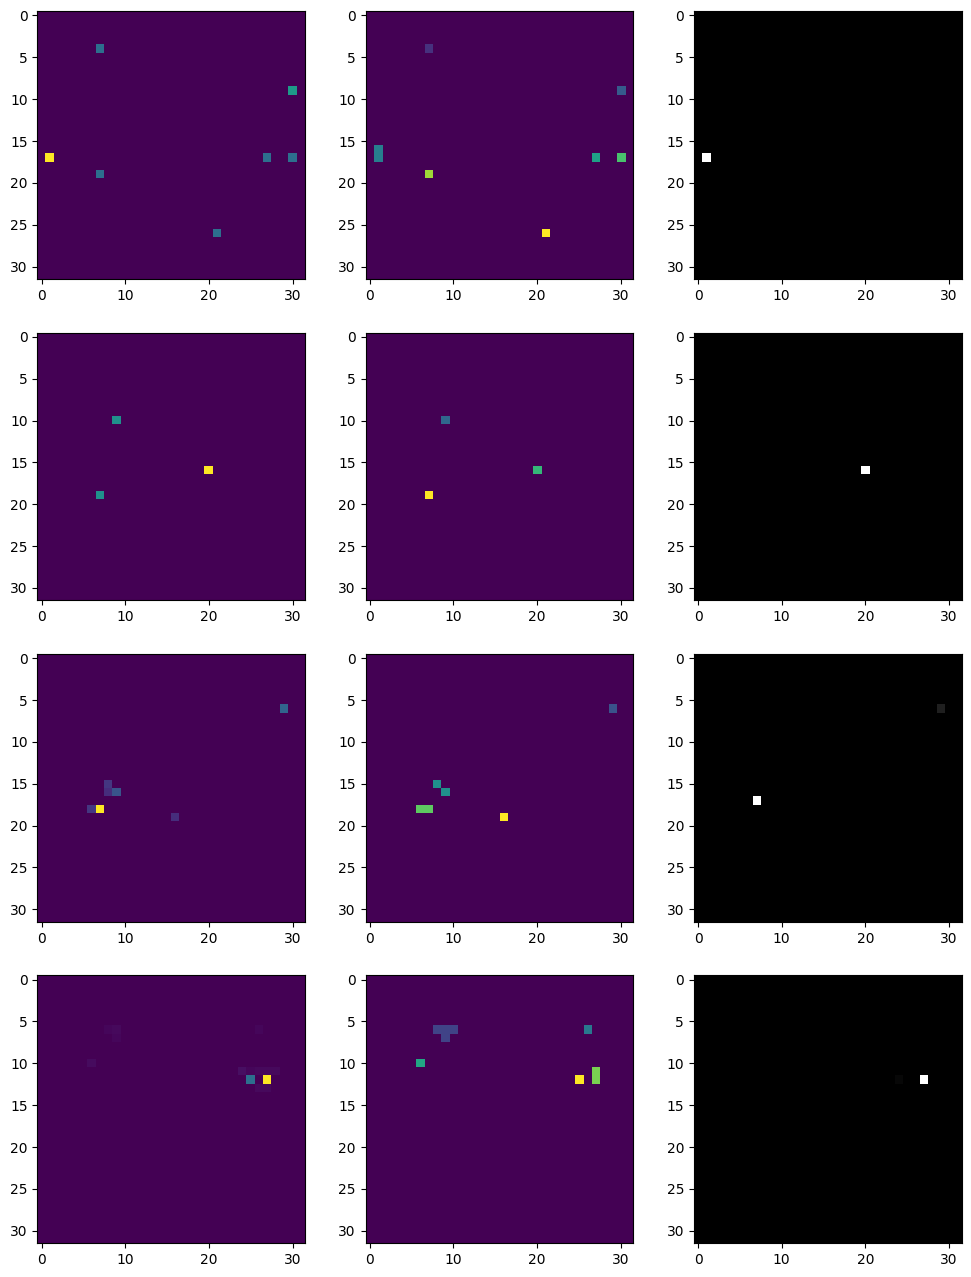

In [378]:
fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))

sample_idxs = [1,4,32,79]
for i, si in enumerate(sample_idxs):
    lpred = ccl_generator(pred_masks[si])
    axs[i][0].imshow(val_imgs[si])
    axs[i][1].imshow(lpred)
    axs[i][2].imshow(val_masks[si], cmap='gray')

## Generating Test Plots

In [379]:
complete_miss_algo = []
complete_miss_pred = []
overlap= []

In [380]:
pred_miss_set = set()

In [ ]:
"""for si in range(len(val_imgs)):
    energy_map = 1 - val_imgs[si][:]
    cluster_pred = ccl_generator(pred_masks[si])
    algo_pred = np.copy(val_masks[si])
    
    for cluster_label in np.unique(cluster_pred):
        # labels iter
        if cluster_label==0:
            continue

        cidx = np.where(cluster_pred==cluster_label)
        energy_pred = np.sum(energy_map[cidx])/3
        energy_algo = np.sum(algo_pred[cidx])

        # energy_algo==0: complete miss
        if energy_algo==0:
            complete_miss_algo.append(energy_pred)
        else:
            # TODO: adjust scale
            overlap.append(energy_algo-energy_pred)

        algo_pred[cidx] = 0.0

    m,n = algo_pred.shape
    for i in range(m):
        for j in range(n):
            if algo_pred[i][j]!=0:
                pred_miss_set.add(si)
                complete_miss_pred.append(algo_pred[i][j])"""

In [381]:
## Added Energy Weighted Balancing in Predictions
for si in range(len(val_imgs)):
    energy_map = val_imgs[si][:]
    cluster_pred = ccl_generator(pred_masks[si])
    algo_pred = np.copy(val_masks[si])
    
    for cluster_label in np.unique(cluster_pred):
        # labels iter
        if cluster_label==0:
            continue

        cidx = np.where(cluster_pred==cluster_label)
        energy_pred = np.sum(energy_map[cidx])/3
        
        # convert pred map to energy prediction map on single point
        try:
            avg_idx = [0,0]
            if energy_pred!=0:
                avg_idx = [int(x) for x in np.sum(cidx*energy_map[cidx], axis=1)/(energy_pred*3)]
        
            if avg_idx!=[0,0]:
                #pred_masks[si][cidx] = 0.0
                #pred_masks[si][avg_idx] = energy_pred
                a =10+2
        except:
            print(energy_pred)
            print(avg_idx)
            raise
        
        energy_algo = np.sum(algo_pred[cidx])
        if energy_algo==0.0:
            energy_algo = algo_pred[avg_idx]

        # energy_algo==0: complete miss
        if energy_algo==0:
            complete_miss_algo.append(energy_pred)
        else:
            # TODO: adjust scale
            overlap.append(energy_algo-energy_pred)

        algo_pred[cidx] = 0.0
        
        # add energy weighted index here to 0.0
        if avg_idx!=[0,0]:
            algo_pred[avg_idx] = 0.0

    m,n = algo_pred.shape
    for i in range(m):
        for j in range(n):
            if algo_pred[i][j]!=0:
                pred_miss_set.add(si)
                complete_miss_pred.append(algo_pred[i][j])

In [382]:
pred_masks.shape, val_masks.shape

((10000, 32, 32, 1), (10000, 32, 32))

[1241  655 1260 3309]


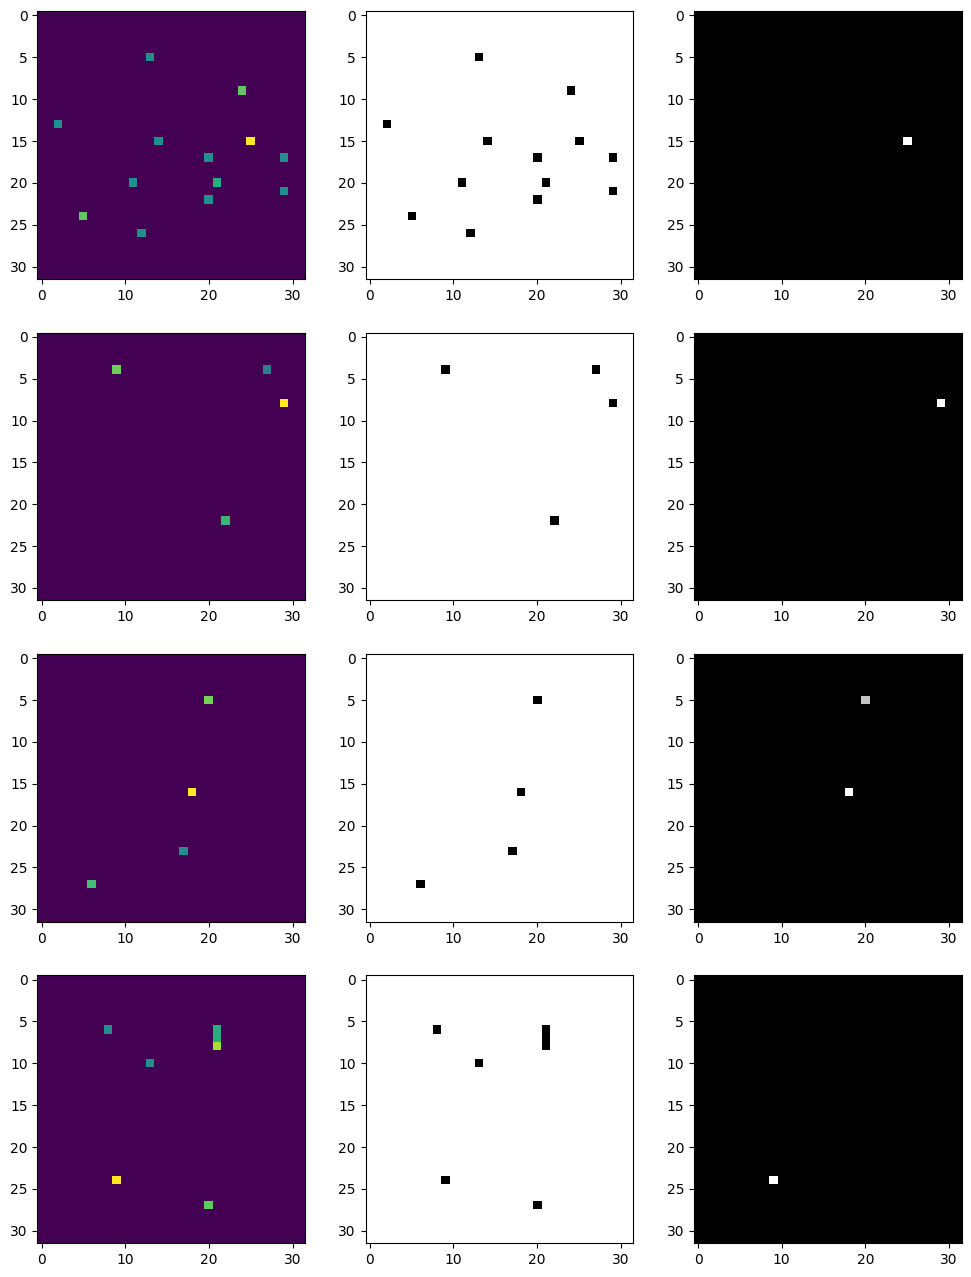

In [383]:
num_example_to_display = 4

sample_idxs = np.random.randint(0, len(pred_masks)-1, size=(num_example_to_display,))
#sample_idxs = [0, 1, 2, 3]
print(sample_idxs)

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))

for i, sample_idx in enumerate(sample_idxs):
    img = val_imgs[sample_idx]
    pred_mask = pred_masks[sample_idx]
    val_mask = val_masks[sample_idx]
    axs[i][0].imshow(img)
    axs[i][1].imshow(pred_mask, cmap='gray')
    axs[i][2].imshow(val_mask, cmap='gray')

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Text(0.5, 0, 'energy difference (algo vs ml)')

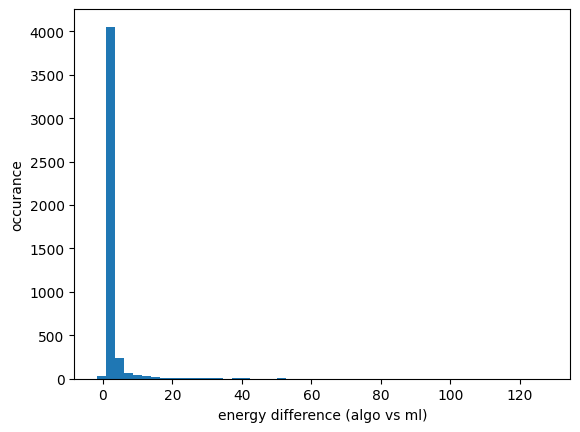

In [384]:
sub_rel = overlap
plt.hist(sub_rel, bins=50)  # density=False would make counts
plt.ylabel('occurance')
plt.xlabel('energy difference (algo vs ml)')

Text(0.5, 0, 'completely missed ml (algo energy)')

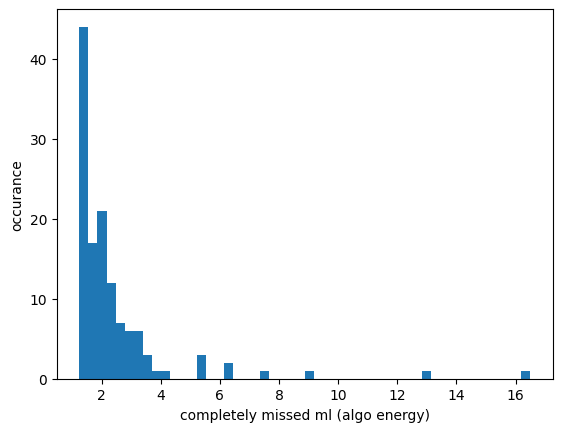

In [385]:
sub_rel = [x for x in complete_miss_pred]
plt.hist(sub_rel, bins=50)  # density=False would make counts
plt.ylabel('occurance')
plt.xlabel('completely missed ml (algo energy)')

Text(0.5, 0, 'completely missed algo (ml pred energy)')

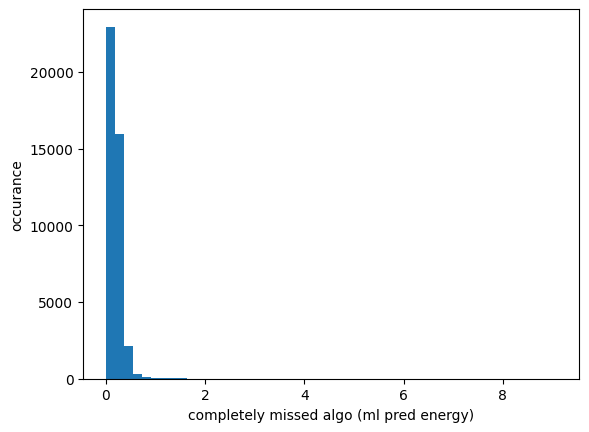

In [386]:
sub_rel = [x for x in complete_miss_algo if x < 10]
plt.hist(sub_rel, bins=50)  # density=False would make counts
plt.ylabel('occurance')
plt.xlabel('completely missed algo (ml pred energy)')